# Проект по А/B-тестированию

# Оглавление <a name="шаг-0"></a>
   [Цели и задачи исследования. Введение](#0)
   
1. [Шаг 1. Исследование данных](#1)


2. [Шаг 2. Исследовательский анализ данных](#2)

    
    2.1. [Исследование конверсии в воронке на разных этапах](#2-1)
    
    2.2. [Обладают ли выборки одинаковыми распределениями количества событий на пользователя?](#2-2)
    
    2.3. [Присутствуют ли в выборках одни и те же пользователи?](#2-3)
    
    2.4. [Как число событий распределено по дням?](#2-4)
    
    2.5. [Есть ли какие-то нюансы данных, которые нужно учесть, прежде чем приступать к A/B-тестированию?](#2-5)
    
    
3. [Шаг 3. Проведение оценки результатов A/B-тестирования](#3)
    
    3.1. [Что можно сказать про результаты A/B-тестирования?](#3-1)
    
    3.2. [Проверка статистической разницы долей z-критерием](#3-2)    
    

4. [Шаг 4. Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования](#4) 


# Цели и задачи исследования. Введение <a name="0"></a>

**Задачи исследования:** 

1) Оценка корректности проведения А/В-теста

Для  оценки корректности проведения теста, необходимо проверить:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

2) Анализ результатов теста

**Техническое задание:**

- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page
    - просмотры корзины — product_card
    - покупки — purchase.


Данные для анализа:


1)	/datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;
  
  Структура файла:
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

2)	/datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

Структура файла:
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

3)	/datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

4)	/datasets/final_ab_participants.csv — таблица участников тестов.

Структура файла:
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.


**Шаги исследования:**

Шаг 1. Исследование данных
 
Шаг 2. Исследовательский анализ данных

- Исследование конверсии в воронке на разных этапах
- Обладают ли выборки одинаковыми распределениями количества событий на пользователя?
- Присутствуют ли в выборках одни и те же пользователи?
- Как число событий распределено по дням?
- Есть ли какие-то нюансы данных, которые нужно учесть, прежде чем приступать к A/B-тестированию?

Шаг 3. Проведение оценки результатов A/B-тестирования

- Что можно сказать про результаты A/B-тестирования?
- Проверка статистической разницы долей z-критерием

Шаг 4. Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования


# Шаг 1. Исследование данных <a name="1"></a>

In [52]:
import pandas as pd
pd.set_option('max_colwidth', 400)
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
from scipy.stats import norm
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
import plotly.express as px
import math

In [53]:
ab_project_marketing_events= pd.read_csv('/datasets/ab_project_marketing_events.csv')
final_ab_new_users= pd.read_csv('/datasets/final_ab_new_users.csv') 
final_ab_events= pd.read_csv('/datasets/final_ab_events.csv') 
final_ab_participants= pd.read_csv('/datasets/final_ab_participants.csv') 

**календарь маркетинговых событий на 2020 год:**

In [54]:
ab_project_marketing_events.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


In [55]:
#приведение к формату дат start_dt и finish_dt
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'], format = '%Y-%m-%d')
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'], format = '%Y-%m-%d')

**все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:**

In [56]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


In [57]:
final_ab_new_users.head(2)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android


In [58]:
#приведение к формату дат first_date
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'], format = '%Y-%m-%d')

In [59]:
final_ab_new_users['first_date'].agg([min, 'max'])

min   2020-12-07
max   2020-12-23
Name: first_date, dtype: datetime64[ns]

In [60]:
final_ab_new_users.duplicated().sum()

0

Аудитория для тестирования - регион EU, поэтому следует удалить   пользователей  других регионов  из таблицы  final_ab_new_users:

In [61]:
final_ab_new_users = final_ab_new_users.query('region =="EU"')

Также по условию дата остановки набора новых пользователей: 2020-12-21, тогда как в таблице данные включают 2 дополнительных дня. Удалим их:

In [62]:
final_ab_new_users = final_ab_new_users.query('first_date <= "2020-12-21"')

In [63]:
final_ab_new_users['first_date'].agg([min, 'max'])

min   2020-12-07
max   2020-12-21
Name: first_date, dtype: datetime64[ns]

**все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:**

In [64]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [65]:
final_ab_events.head(2) 

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99


In [66]:
final_ab_events['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

In [67]:
final_ab_events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Пропущены данные в details. Это те данные, которые зафиксированы по столбцу соответствуют только purchase. Очевидно, по типам событий выстраивается воронка, где purchase  - покупка "в один клик" и данные по стоимости продукции по какой-то технической причине зафиксированы в details.   Прочие клиенты перешли в корзину  product_cart, однако, данных по стоимости  покупки для корзины нам недоступны.        

In [68]:
#приведение к формату дат  
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format = '%Y-%m-%d %H:%M:%S')

In [69]:
final_ab_events['event_dt'].agg([min, 'max'])

min   2020-12-07 00:00:33
max   2020-12-30 23:36:33
Name: event_dt, dtype: datetime64[ns]

In [70]:
final_ab_events.duplicated().sum()

0

**таблица участников тестов:**

In [71]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


In [72]:
final_ab_participants.head(2) 

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test


In [73]:
final_ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [74]:
final_ab_participants['group'].value_counts()

A    9655
B    8613
Name: group, dtype: int64

In [75]:
final_ab_participants.duplicated().sum()

0

In [76]:
#проверим пересечение аудиторий:
recomm_system_test = final_ab_participants.query('ab_test == "recommender_system_test"') #тестовая
interf_eu_test = final_ab_participants.query('ab_test == "interface_eu_test"')#конкурирующий тест
recomm_system_test.merge(interf_eu_test, how='inner', on = 'user_id').shape[0]

1602

По условиям используем тест recommender_system_test:

In [77]:
final_ab_participants = final_ab_participants.query('ab_test =="recommender_system_test"')

# Выводы:
- Изменён формат записи дат
- Таблицы не содержат дубликаты
- Пропуски содержатся только в таблице final_ab_events
- Удалены данные, не соответствующие условиям исследования.

# Шаг 2. Исследовательский анализ данных <a name="2"></a>

## 2.1. Исследование конверсии в воронке на разных этапах <a name="2-1"></a>

Для анализа воронки проанализируем данные из таблицы final_ab_events. Здесь представлено 4 вида событий: login - регистрация, переход на страницу с товарами - product_page, покупка в один клик  - purchase и продуктовая корзина - product_cart.

In [78]:
final_ab_events.head(2) 

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99


In [79]:
#создаем Series с данными по каждому этапу воронки
login_funnel = final_ab_events.query('event_name == "login"').groupby('event_name')['user_id'].nunique().sum()
product_page_funnel = final_ab_events.query('event_name == "product_page"').groupby('event_name')['user_id'].nunique().sum()
purchase_funnel = final_ab_events.query('event_name == "purchase"').groupby('event_name')['user_id'].nunique().sum()
product_cart_funnel = final_ab_events.query('event_name == "product_cart"').groupby('event_name')['user_id'].nunique().sum()

In [80]:
#строим воронку
fig = go.Figure(go.Funnel(y = ["login", "product_page", "purchase", "product_cart"],x = [login_funnel, product_page_funnel, purchase_funnel, product_cart_funnel]))
fig.show()

Конверсии по переходам: 
- переход с login на product_page: 66.3%
- переход с product_page на purchase:50.3% (33.3% по сравнению с числом зарегистрировавшихся пользователей)
- переход с purchase на product_cart: 98.5% (32.9% по сравнению с числом зарегистрировавшихся пользователей)

Воронка показывает, что на шаге purchase больше пользователей, чем на предыдущем шаге product_cart. Вероятно, это связано с кнопкой «купить сейчас», которая может предлагать пользователям покупать продукты, пропуская некоторые шаги, и переходить непосредственно к этапу покупки. 

Для понимания последовательности событий (корзина или прямая покупка) посмотрим на примере нескольких пользователей  путь клиента:

In [81]:
final_ab_events.query('user_id == "E1BDDCE0DAFA2679"').sort_values(by='event_dt', ascending=True)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
250769,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,NaN
3379,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99
261125,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,NaN
53604,E1BDDCE0DAFA2679,2020-12-25 08:26:03,purchase,499.99
412654,E1BDDCE0DAFA2679,2020-12-25 08:26:03,login,NaN


In [82]:
final_ab_events.query('user_id == "9CD9F34546DF254C"').sort_values(by='event_dt', ascending=True)

,user_id,event_dt,event_name,details
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
1650,9CD9F34546DF254C,2020-12-08 07:21:15,purchase,99.99
5072,9CD9F34546DF254C,2020-12-10 15:12:25,purchase,4.99
266356,9CD9F34546DF254C,2020-12-10 15:12:25,login,NaN
135569,9CD9F34546DF254C,2020-12-10 15:12:26,product_page,NaN
9042,9CD9F34546DF254C,2020-12-12 09:41:48,purchase,4.99
278400,9CD9F34546DF254C,2020-12-12 09:41:48,login,NaN
143549,9CD9F34546DF254C,2020-12-12 09:41:51,product_page,NaN


In [83]:
final_ab_events.query('user_id == "7AEC61159B672CC5"').sort_values(by='event_dt', ascending=True)

,user_id,event_dt,event_name,details
251565,7AEC61159B672CC5,2020-12-07 21:25:59,login,NaN
63003,7AEC61159B672CC5,2020-12-07 21:26:00,product_cart,NaN
125727,7AEC61159B672CC5,2020-12-07 21:26:00,product_page,NaN
128703,7AEC61159B672CC5,2020-12-08 04:18:30,product_page,NaN
256074,7AEC61159B672CC5,2020-12-08 04:18:30,login,NaN
64457,7AEC61159B672CC5,2020-12-08 04:18:34,product_cart,NaN
93598,7AEC61159B672CC5,2020-12-19 22:13:37,product_cart,NaN
344618,7AEC61159B672CC5,2020-12-19 22:13:37,login,NaN
187436,7AEC61159B672CC5,2020-12-19 22:13:38,product_page,NaN
366405,7AEC61159B672CC5,2020-12-21 17:22:38,login,NaN


Анализ трёх случайных id позволил увидеть, что клиент может сделать быструю покупку уже на продуктовой странице или даже на странице регистрации. Иногда клиенту удается сразу, минуя, все ступени, сразу осуществить покупку (внешние ссылки?).

## 2.2. Обладают ли выборки одинаковыми распределениями количества событий на пользователя? <a name="2-2"></a>

Используем таблицу final_ab_participants:

In [84]:
final_ab_participants['group'].value_counts() 

A    3824
B    2877
Name: group, dtype: int64

посчитаем для каждого уникального пользователя приходящееся на него кол-во событий:

In [85]:
final_ab_events_group_by_user = final_ab_events.groupby('user_id')['event_name'].count().reset_index()
final_ab_events_group_by_user.head()

,user_id,event_name
0,0001710F4DDB1D1B,6
1,000199F1887AE5E6,16
2,0002499E372175C7,9
3,0002CE61FF2C4011,12
4,000456437D0EFFE1,4


In [86]:
#объединим таблицы
final_ab_participants_group = final_ab_events_group_by_user.merge(final_ab_participants, how='inner', on = 'user_id')
final_ab_participants_group.head()

,user_id,event_name,group,ab_test
0,001064FEAAB631A1,6,B,recommender_system_test
1,0010A1C096941592,12,A,recommender_system_test
2,00341D8401F0F665,2,A,recommender_system_test
3,003DF44D7589BBD4,15,A,recommender_system_test
4,00505E15A9D81546,5,A,recommender_system_test


разобъём на группы:

In [87]:
final_ab_participants_A = final_ab_participants_group.query('group =="A"')
final_ab_participants_B = final_ab_participants_group.query('group =="B"')

In [88]:
final_ab_participants_A['event_name'].count()

2747

In [89]:
final_ab_participants_B['event_name'].count()

928

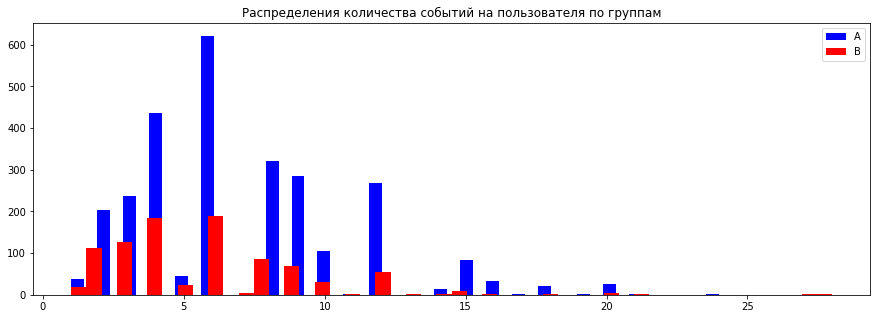

In [90]:
plt.figure(figsize=(15, 5))
plt.hist(final_ab_participants_A['event_name'],  color='blue', bins =50)
plt.hist(final_ab_participants_B['event_name'],  color='red', bins =50)
plt.title('Распределения количества событий на пользователя по группам')
plt.legend(['A','B'])
plt.show();

In [91]:
final_ab_participants_group['user_id'].nunique()

3675

In [92]:
final_ab_participants_A['event_name'].describe()

count    2747.000000
mean        7.027303
std         3.868983
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
Name: event_name, dtype: float64

In [93]:
final_ab_participants_B['event_name'].describe()

count    928.000000
mean       5.812500
std        3.483878
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       28.000000
Name: event_name, dtype: float64

Если не учитывать порядок значений числа событий в контрольной группе  А и группе В, визуально распределение выборок выглядит  одинаковым. Статитсические показатели также достаточно близки. 

## 2.3. Присутствуют ли в выборках одни и те же пользователи? <a name="2-3"></a>

In [94]:
final_ab_participants_A.merge(final_ab_participants_B, how='inner', on = 'user_id').shape[0]

0

или так:

In [95]:
final_ab_participants_group.shape[0] - final_ab_participants_group['user_id'].nunique()

0

В выборках по группам А и В отстутствуют совпадения по пользователям.

## 2.4. Как число событий распределено по дням?<a name="2-4"></a>

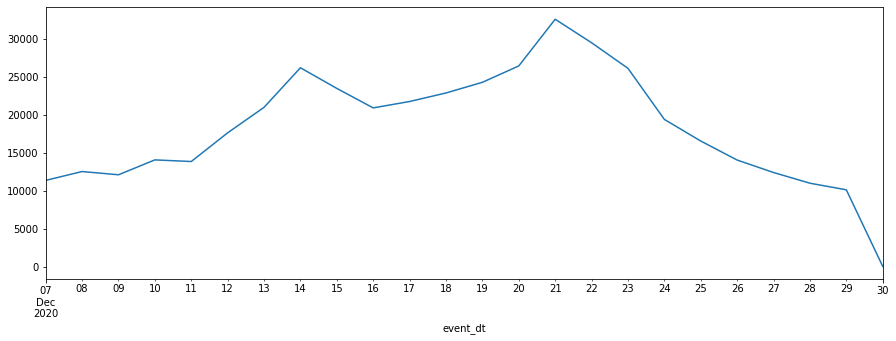

In [96]:
events_date_filtered = final_ab_events.resample('D', on='event_dt')['event_name'].count()
events_date_filtered.plot(figsize=(15, 5));

Количество событий распределено по дням неравномерно: до 2020-12-14 число событий растёт и затем уверенно идёт на спад. Исследуемый период показывает два пика: 14  и 21 декабря. Спад после 21 декабря объясняется тем, что была совершена остановка набора новых пользователей. Спад после  14 декабря, возможно, связан с окончанием какого-то ивента, что легко проверить:

In [97]:
ab_project_marketing_events 

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


2020-11-26 стартовала кампания Black Friday Ads, которая закончилась 1 декабря. Возможно, именно это событие всё еще влияло на рост числа событий. 

## 2.5. Есть ли какие-то нюансы данных, которые нужно учесть, прежде чем приступать к A/B-тестированию?<a name="2-5"></a>

По условиям, дата остановки теста 2021-01-04, но таблицы содержат данные только до 2020-12-30.


# Шаг 3. Проведение оценки результатов A/B-тестирования<a name="3"></a>

## 3.1. Что можно сказать про результаты A/B-тестирования?<a name="3-1"></a>

построим удобную воронку по количеству событий для каждого теста:

In [98]:
#объединим таблицы
data = final_ab_events.merge(final_ab_participants, how = 'inner', on = 'user_id')

In [99]:
#подготовим данные для новой воронки
login_A = data.query('event_name == "login" & group == "A"').groupby('event_name')['user_id'].nunique().sum()
product_page_A = data.query('event_name == "product_page" & group == "A"').groupby('event_name')['user_id'].nunique().sum()
purchase_A = data.query('event_name == "purchase" & group == "A"').groupby('event_name')['user_id'].nunique().sum()
product_cart_A = data.query('event_name == "product_cart" & group == "A"').groupby('event_name')['user_id'].nunique().sum()

login_B = data.query('event_name == "login" & group == "B"').groupby('event_name')['user_id'].nunique().sum()
product_page_B = data.query('event_name == "product_page" & group == "B"').groupby('event_name')['user_id'].nunique().sum()
purchase_B= data.query('event_name == "purchase" & group == "B"').groupby('event_name')['user_id'].nunique().sum()
product_cart_B = data.query('event_name == "product_cart" & group == "B"').groupby('event_name')['user_id'].nunique().sum()

In [100]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = ["login", "product_page", "purchase", "product_cart"],
    x = [login_A, product_page_A, purchase_A,  product_cart_A],
    textinfo = "value+percent previous+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = ["login", "product_page", "purchase", "product_cart"],
    x = [login_B,product_page_B, purchase_B, product_cart_B],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"))

fig.show()

Из воронки видно, что переходс login на product_page для  группы А совершает 64,8% пользователей. Этот же показатель для группы  В составляет 56,4%.  На шаг purchase с предыдущего шага  приходит 49% пользователей группы А и  48,9%  группы В.

На шаг product_cart  по сравнению с login перешло 30% группы А и 27,5% группы В.

Ожидалось, что за период теста пользователи  покажут увеличение  каждой метрики не менее, чем на 10%. Однако, показатели не изменились, и, в некоторых случаях, даже снизились. 

## 3.2. Проверка  статистической разницы долей z-критерием<a name="3-2"></a>

Считаем статистическую достоверность отличия между группами в разрезе событий. 
Сформулируем гипотезы:

- H0 - нулевая гипотеза: нет статистически значимой разницы в конверсии между группами A и B для различных событий
- H1 - альтернативная гипотеза :  существует статистически значимая разница в конверсии между группами A и B для различных событий.  

In [101]:
#скидываем данные в таблицу: 
exp_groups = data.pivot_table(index='event_name', values='user_id', columns='group', aggfunc=lambda x: x.nunique()).reset_index()
group1 = 'A'
group2 = 'B'
alpha = 0.05

In [102]:
exp_groups

group,event_name,A,B
0,login,2747,928
1,product_cart,824,255
2,product_page,1780,523
3,purchase,872,256


In [103]:
for event in exp_groups.event_name.unique():

    successes1 = exp_groups[exp_groups.event_name == event][group1].iloc[0]
    successes2 = exp_groups[exp_groups.event_name == event][group2].iloc[0]

    trials1 = data[data.group == group1]['user_id'].nunique()
    trials2 = data[data.group == group2]['user_id'].nunique()

    #пропорция успехов в первой группе:
    p1 = successes1 / trials1

    #пропорция успехов во 2 группе:
    p2 = successes2 / trials2

    #пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    #разница пропорций в датасетах
    difference = p1 - p2
    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0,1)

    #считаем p_value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p_value: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу для события", event)
    else:
        print("Не получилось отвергнуть нулевую гипотезу для события", event)

p_value:  nan
Не получилось отвергнуть нулевую гипотезу для события login
p_value:  0.14534814557238196
Не получилось отвергнуть нулевую гипотезу для события product_cart
p_value:  4.310980554755872e-06
Отвергаем нулевую гипотезу для события product_page
p_value:  0.017592402663314743
Отвергаем нулевую гипотезу для события purchase


# Выводы:

Статистически значимая разница в конверсии между группами A и B существует только в случае событий product_page и purchase.


# Шаг 4. Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования <a name="4"></a>

Результаты теста по оценке изменений, связанных с внедрением улучшенной рекомендательной системы, не вызывают доверия. 
Причина неудачи может связана со следущими некорректно организованными моментами:

1) В результате анализа было обнаружено пересечение аудиторий recommender_system_test (тестовая аудитория) и interface_eu_test (конкурирующий тест): количество совпадений составило 1602 пользователя.

2) Также тест проведён не полностью: по условиям, дата остановки теста 2021-01-04, но таблицы содержат данные только до 2020-12-30.

3) Также, вероятно, следовало совместить дату остановки набора новых пользователей (21 января) с датой остановки теста (4 января).   

4) 2020-11-26 стартовала кампания Black Friday Ads, которая закончилась 1 декабря. Возможно, именно это событие оказало влияние  на рост числа событий и фактор влияния эффекта от внедрения улучшенной рекомендательной системы размыт.

5) Кроме того, не оправдалось ожидаемое количество участников теста - 6000 пользователей, следовательно, была использована слишком маленькая выборка.



**Статистическое подтверждение:**
Целью этого исследования было определить, повлияет ли внедрение изменений на конверсию пользователей. Ожидалось, что  пользователи покажут увеличение конверсии на 10% для каждого шага событий: login, product_cart, product_page, purchase.

В результате исследовательского анализа данных было обнаружено, что 30% пользователей в группе A (контрольная группа) совершили  покупку, в то время как 27,5% пользователей в группе B (внедрение улучшенной рекомендательной системы) совершили конверсию. Эти данные свидетельствуют о том, что улучшения  не привели к увеличению конверсии. Скорее произошло некоторое её снижение.

В результате анализа данных внедрение улучшенной рекомендательной системы не оправдано. Возможно, магазину следует придерживаться своей текущей модели или изменить систему рекомендаций. 